# Recommendations with IBM

 describes IBM's use of Recommendation X and related recommendations of the International Telegraph and Telephone Consultative Committee. After reviewing the development history of X and some of the motivations for using it, the paper gives an overview of packet-switched data networks. The reader is then given a brief technical description of Recommendation X and some other recommendations used in conjunction with X. The architectural relationships between X and IBM's Systems Network Architecture (SNA) are described for packet-switched X connections between SNA and non-SNA nodes. Specific elements of Recommendation X used in SNA nodes are defined. After several IBM products that support X and some of the related recommendations are described, IBM's equipment for testing the X interface is discussed.


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>


In [1]:
# pip install matplotlib

In [2]:
# import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle
import seaborn as sns
sns.set()
%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_articles_community = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_articles_community['Unnamed: 0']

In [3]:
# Show df to To see dataframe of user item interactions
df.head(5)

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [4]:
# Show df_articles_community to see the dataframe of articles community
df_articles_community.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I :Analysis Data and Exploreing It </a>


In [5]:
#Show The Shape Of Data df
df.shape

(45993, 3)

In [6]:
# get median of article_id grouping by Email
df.groupby('email')['article_id'].count().median()

3.0

In [7]:
# get MAX of article_id grouping by Email
df.groupby('email')['article_id'].count().max()

364

In [8]:
# median and maximum number of user_article interactions

median_user_article = df.groupby('email')['article_id'].count().median()
maxviewed = df.groupby('email')['article_id'].count().max()

In [9]:
interact_form_user = df.groupby('email')['article_id'].count()
interact_form_user

email
0000b6387a0366322d7fbfc6434af145adf7fed1    13
001055fc0bb67f71e8fa17002342b256a30254cd     4
00148e4911c7e04eeff8def7bbbdaf1c59c2c621     3
001a852ecbd6cc12ab77a785efa137b2646505fe     6
001fc95b90da5c3cb12c501d201a915e4f093290     2
                                            ..
ffc6cfa435937ca0df967b44e9178439d04e3537     2
ffc96f8fbb35aac4cb0029332b0fc78e7766bb5d     4
ffe3d0543c9046d35c2ee3724ea9d774dff98a32    32
fff9fc3ec67bd18ed57a34ed1e67410942c4cd81    10
fffb93a166547448a0ff0232558118d59395fecd    13
Name: article_id, Length: 5148, dtype: int64

In [10]:
# Get the summary of user_interacts
interact_form_user.describe()

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: article_id, dtype: float64

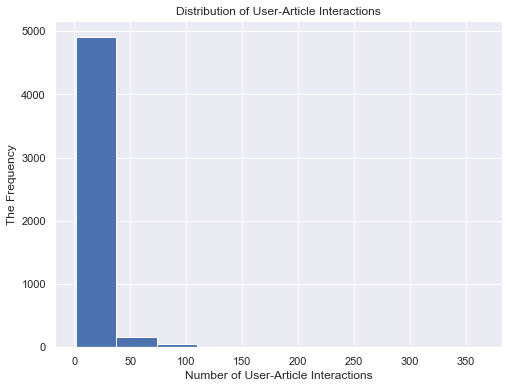

In [11]:
# plot graph to view Distribution of User-Article Interactions
plt.figure(figsize=(8,6))
interact_form_user.plot(kind='hist')
plt.title('Distribution of User-Article Interactions') 
plt.xlabel('Number of User-Article Interactions');
plt.ylabel('The Frequency');

`2.` Explore and remove duplicate articles from the **df_articles_community** dataframe.  

In [12]:
# Show df_articles_community to see the dataframe of articles community
df_articles_community.head(5)

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [13]:
#Show The Shape Of Data df_articles_community
df_articles_community.shape

(1056, 5)

In [14]:
# get duplicate articles
df_articles_community.article_id.duplicated().sum()

5

In [15]:
article_ids = df_articles_community['article_id']

In [16]:
print(article_ids)

0          0
1          1
2          2
3          3
4          4
        ... 
1051    1046
1052    1047
1053    1048
1054    1049
1055    1050
Name: article_id, Length: 1056, dtype: int64


In [17]:
df_articles_community[article_ids.isin(article_ids[article_ids.duplicated()])]

,doc_body,doc_description,doc_full_name,doc_status,article_id
50,Follow Sign in / Sign up Home About Insight Da...,Community Detection at Scale,Graph-based machine learning,Live,50
221,* United States\r\n\r\nIBM® * Site map\r\n\r\n...,When used to make sense of huge amounts of con...,How smart catalogs can turn the big data flood...,Live,221
232,Homepage Follow Sign in Get started Homepage *...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
399,Homepage Follow Sign in Get started * Home\r\n...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
578,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


In [18]:
# Remove any rows that have the same article_id 
df_articles_community.drop_duplicates(subset=['article_id'], keep='first', inplace=True)

In [19]:
df_articles_community.iloc[100]

doc_body           Skip navigation Sign in SearchLoading...\r\n\r...
doc_description    This video shows you how to add a data asset t...
doc_full_name      Use data assets in a project using IBM Data Ca...
doc_status                                                      Live
article_id                                                       100
Name: 100, dtype: object

### `3.`  Find unique articles ,unique users ,user-article interactions in the dataset.

In [20]:
print(df.shape)
print(df_articles_community.shape)

(45993, 3)
(1051, 5)


In [21]:
# The number of unique articles 
df.article_id.nunique()

714

In [22]:
# The number of unique articles 
df_articles_community.article_id.nunique()

1051

In [23]:
# The number of unique users
df.email.nunique()

5148

In [24]:
# The number of user-article interactions
df.shape[0]

45993

In [25]:
unique_articles = df.article_id.nunique() 
total_articles =  df_articles_community.article_id.nunique() 
unique_users = df.email.nunique()
user_article_interactions = df.shape[0] 

In [26]:
print("The number of unique articles =",unique_articles)
print("The number of unique articles on the df_articles_community =",total_articles)
print("The number of unique users =",unique_users)
print("The number of user-article shape =",user_article_interactions)

The number of unique articles = 714
The number of unique articles on the df_articles_community = 1051
The number of unique users = 5148
The number of user-article shape = 45993


### `4.`  Find the most viewed article_id.

In [27]:
# The max of viewed  article_id
df.article_id.value_counts().max()

937

In [28]:
most_viewed_article_id = str(df.article_id.value_counts().index[0]) 
max_views = df.article_id.value_counts().iloc[0]

In [29]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [30]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_user_article,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': maxviewed,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Traditional recommendation algorithms use the predicted rating scores to represent the degree of user preference, called rating-based recommendation methods. Recently, ranking-based algorithms have been proposed and widely used, which use ranking to present the 

### `1.` Get The **n** top articles ordered 

In [31]:
def Find_Max_articles(n, df=df):
  
    get_max_articles = df['title'].value_counts().index.tolist()[:n]
    get_max_articles = [str(i) for i in get_max_articles]
    
    return get_max_articles 

def get_top_article_ids(n, df=df):
    
    get_max_articles = df['article_id'].value_counts().index.tolist()[:n]
    get_max_articles = [str(i) for i in get_max_articles]

    return get_max_articles 

In [32]:
print("The Top Ten Articles = \n",Find_Max_articles(10))
print("************************************************************************************************************************")
print("The Top Ten Articles IDs = \n",get_top_article_ids(10))

The Top Ten Articles = 
 ['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
************************************************************************************************************************
The Top Ten Articles IDs = 
 ['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [33]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = Find_Max_articles(5)
top_10 = Find_Max_articles(10)
top_20 = Find_Max_articles(20)

# Test each of your three lists from above
t.sol_2_test(Find_Max_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>

In [34]:

def create_user_item_matrix(df):

    df_count = df.groupby(['user_id', 'article_id']).count().reset_index()
    user_item = df_count.pivot_table(values='title', index='user_id', columns='article_id') 
    user_item.replace(np.nan, 0, inplace=True) 
    user_item=user_item.applymap(lambda x: 1 if x > 0 else x) 

    return user_item

user_item = create_user_item_matrix(df)


In [35]:
print("the user_item matrix = \n",user_item)

the user_item matrix = 
 article_id  0.0     2.0     4.0     8.0     9.0     12.0    14.0    15.0    \
user_id                                                                      
1              0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2              0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3              0.0     0.0     0.0     0.0     0.0     1.0     0.0     0.0   
4              0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
5              0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
...            ...     ...     ...     ...     ...     ...     ...     ...   
5145           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
5146           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
5147           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
5148           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
5149           0.0     0.0     0.0     

In [36]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


### `2.` Get the  users in order from most to least similar

In [37]:
def find_similar_users(user_id, user_item=user_item):

    users_dot_product = user_item.dot(np.transpose(user_item))
 
    similar_users = users_dot_product[user_id].sort_values(ascending = False)
   
    most_similar_users = similar_users.index.tolist()
    
    most_similar_users.remove(user_id)
       
    return most_similar_users

In [38]:
print("The 6 most similar users_to_user 5 are: {}".format(find_similar_users(5)[:6]))
print("The 8 most similar users_to_user 3900 are: {}".format(find_similar_users(3900)[:8]))
print("The 12 most similar users_to_user 50 are: {}".format(find_similar_users(50)[:12]))

The 6 most similar users_to_user 5 are: [3782, 4145, 3784, 912, 371, 49]
The 8 most similar users_to_user 3900 are: [3944, 2183, 619, 3073, 4842, 3621, 4722, 4231]
The 12 most similar users_to_user 50 are: [3478, 49, 3697, 3596, 52, 3559, 4526, 268, 290, 4250, 518, 23]


### `3.` Get the articles we would recommend to each user. 

In [39]:
def get_names_of_article(article_ids, df=df):

    names_of_article = []

    for idx in article_ids:
        names_of_article.append(df[df['article_id']==float(idx)].max()['title'])
    
    return names_of_article 

def get_user_articles(user_id, user_item=user_item):

    article_ids = user_item.loc[user_id][user_item.loc[user_id] == 1].index.astype('str')
    
    names_of_article = []

    for idx in article_ids:
        names_of_article.append(df[df['article_id']==float(idx)].max()['title'])
    return article_ids, names_of_article


def user_user_recs(user_id, m = 10):
   
    recs = np.array([]) 
    
    user_articles_seen = get_user_articles(user_id)[0] 
    closest_users = find_similar_users(user_id)
    
    for others in closest_users:
        
        others_articles_seen = get_user_articles(others)[0]
        new_recs = np.setdiff1d(others_articles_seen, user_articles_seen, assume_unique=True) 
        recs = np.unique(np.concatenate([new_recs, recs], axis = 0))

        if len(recs) > m-1:
            break
            
    recs = recs[:m]
    recs.tolist()
    
    return recs 

In [40]:
# Check Results
get_names_of_article(user_user_recs(3, 15)) 

['recommender systems: approaches & algorithms',
 '1448    i ranked every intro to data science course on...\nName: title, dtype: object',
 'data tidying in data science experience',
 'a tensorflow regression model to predict house values',
 'access db2 warehouse on cloud and db2 with python',
 '520    using notebooks with pixiedust for fast, flexi...\nName: title, dtype: object',
 'airbnb data for analytics: mallorca reviews',
 'airbnb data for analytics: vancouver listings',
 'analyze facebook data using ibm watson and watson studio',
 'analyze accident reports on amazon emr spark',
 'analyze energy consumption in buildings',
 'analyze open data sets with spark & pixiedust',
 'analyze open data sets with pandas dataframes',
 'analyzing data by using the sparkling.data library features',
 'apache spark lab, part 1: basic concepts']

In [41]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_names_of_article(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_names_of_article function doesn't work quite how we expect."
assert set(get_names_of_article(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_names_of_article function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


### `4.` Now we are going to improve the consistency of the **user_user_recs** function 

In [42]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):

    neighbors_df = pd.DataFrame(columns=['neighbor_id', 'similarity'])
    neighbors_df['neighbor_id'] = user_item.index-1
    users_dot_product = user_item.dot(np.transpose(user_item))
    neighbors_df['similarity'] = users_dot_product[user_id]
    interacts_df = df.user_id.value_counts().rename_axis('neighbor_id').reset_index(name='num_interactions')
    neighbors_df = pd.merge(neighbors_df, interacts_df, on='neighbor_id', how='outer')
    neighbors_df = neighbors_df.sort_values(by=['similarity', 'num_interactions'], ascending = False)
    neighbors_df = neighbors_df.reset_index(drop=True)
    neighbors_df = neighbors_df[neighbors_df.neighbor_id != user_id]
    
    return neighbors_df


def user_user_recs_part2(user_id, m=10):
    
    recs = np.array([])
    
    user_articles_ids_seen, user_articles_names_seen = get_user_articles(user_id, user_item) 
    closest_neighs = get_top_sorted_users(user_id, df, user_item).neighbor_id.tolist()
    
    for neighs in closest_neighs:
        
        neigh_articles_ids_seen, neigh_articles_names_seen = get_user_articles(neighs, user_item) 
        new_recs = np.setdiff1d(neigh_articles_ids_seen, user_articles_ids_seen, assume_unique=True)
        recs = np.unique(np.concatenate([new_recs, recs], axis = 0))

        if len(recs) > m-1:
            break
            
    recs = recs[:m]
    recs = recs.tolist()
    
    rec_names = get_names_of_article(recs, df=df)
    
    return recs, rec_names

In [43]:
rec_ids, rec_names = user_user_recs_part2(50, 5)
print("The top 5 recommendations for user 50 are the following article ids:")
print(rec_ids)
print()
print("The top 5 recommendations for user 50 are the following article names:")
print(rec_names)

The top 5 recommendations for user 50 are the following article ids:
['1044.0', '1047.0', '1053.0', '111.0', '1162.0']

The top 5 recommendations for user 50 are the following article names:
['mapping points with folium', 'a comparison of logistic regression and naive bayes ', 'access mysql with python', 'tidy up your jupyter notebooks with scripts', 'analyze energy consumption in buildings']


`5.` The functions from above are now used to correctly fill in the solutions to the dictionary below.

In [44]:
user1_most_sim = get_top_sorted_users(1).iloc[0].neighbor_id
user131_10th_sim = get_top_sorted_users(131).iloc[9].neighbor_id

In [45]:

sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


### `6.`  provide for the a new user .  

In [46]:
new_user = '0.0'
new_user_recs = get_top_article_ids(10, df)

In [47]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!
